In [4]:
%load_ext autoreload

import sys
sys.path.append('..')

import sys
from pathlib import Path

# Ajouter le répertoire racine du projet
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


In [5]:
import scipy.io
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random
import torch

In [6]:
amd_data_path = "/Users/anessad/Documents/PROJETS/OCT-AMD-Segmentation/data/raw/2015_BOE_Chiu"
amd_data_files = os.listdir(amd_data_path)

In [7]:
amd = [scipy.io.loadmat( amd_data_path + "/" + x) for x in amd_data_files]

In [8]:
amd[0].keys()

dict_keys(['__header__', '__version__', '__globals__', 'images', 'automaticFluidDME', 'manualFluid1', 'manualFluid2', 'automaticLayersDME', 'automaticLayersNormal', 'manualLayers1', 'manualLayers2'])

(496, 768, 61)
(496, 768)


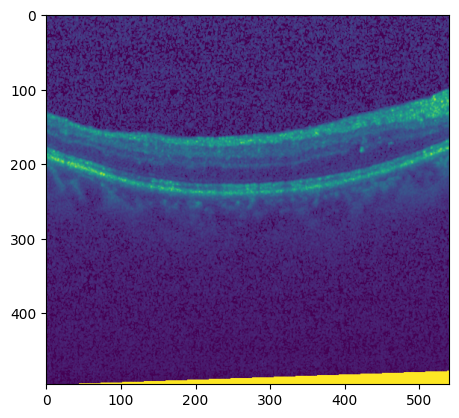

In [9]:
imgs = amd[0]["images"]
img = amd[0]["images"][:,:,15]

print(imgs.shape)
print(img.shape)

plt.imshow(img[:,125:666])

In [10]:
map  = amd[0]["manualLayers1"][:,:,15]
print(map.shape)
print(map[0].shape)

(8, 768)
(768,)


In [11]:
np.unique(map[7])

array([183., 184., 185., 186., 187., 188., 189., 190., 191., 192., 193.,
       194., 195., 196., 197., 198., 199., 200., 201., 202., 203., 204.,
       205., 206., 207., 208., 209., 210., 211., 212., 213., 214., 215.,
       216., 217., 218., 219., 220., 221., 222., 223., 224., 225., 226.,
       227., 228., 229., 230., 231., 232., 233., 234., 235., 236., 237.,
       238., 239., 240., 241., 242., 243., 244.,  nan])

In [12]:
blank = np.zeros(img.shape[:2], dtype=np.uint8)  # Image 2D
step = 1

for i in range(len(map)-1):
    l_line = []
    u_line = []
    for (j1, y1), (j2, y2) in zip(enumerate(map[i]), enumerate(map[i+1])):
        if not np.isnan(y1) and not np.isnan(y2):
            u_line.append([j1, int(y1)])
            l_line.append([j2, int(y2)])
    
    if len(u_line) > 0: 
        l_line = np.array(l_line)
        u_line = np.array(u_line)
        l_line = l_line[::-1]
        
        polygone = np.concatenate([u_line, l_line]).astype(np.int32)
        
        cv.fillPoly(blank, [polygone], color=step)
        step += 1

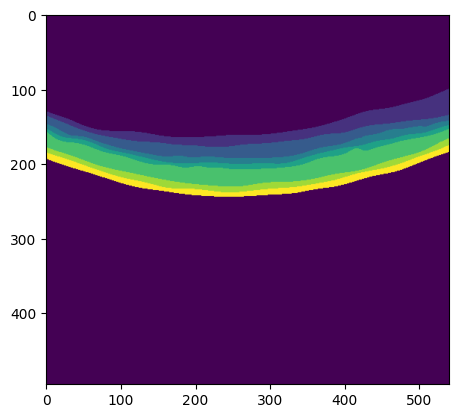

In [13]:
# plt.imshow(img[:,125:666])
plt.imshow(blank[:,125:666])

In [ ]:
def create_mask(image, bounds):
    blank = np.zeros(image.shape[:2], dtype=np.uint8)  # Image 2D
    step = 1
    inf_lim , sup_lim = int(np.where(~np.isnan(bounds[7]))[0][0]), int(np.where(~np.isnan(bounds[7]))[0][-1])

    for i in range(len(bounds)-1):
        l_line = []
        u_line = []
        for (j1, y1), (j2, y2) in zip(enumerate(bounds[i]), enumerate(bounds[i+1])):
            if not np.isnan(y1) and not np.isnan(y2):
                u_line.append([j1, int(y1)])
                l_line.append([j2, int(y2)])
        
        if len(u_line) > 0: 
            l_line = np.array(l_line)
            u_line = np.array(u_line)
            l_line = l_line[::-1]
            
            polygone = np.concatenate([u_line, l_line]).astype(np.int32)
            
            cv.fillPoly(blank, [polygone], color=step)
            step += 1

    mask = blank[:,inf_lim:sup_lim] 

    
    return mask, (inf_lim,sup_lim)
    

In [69]:
masks = []
images = []

for i in range(10):
    imgs = amd[i]["images"]
    bounds = amd[i]["manualLayers1"]

    for j in range(bounds.shape[2]):
        bound = bounds[:,:,j]
        if len(np.unique(bound)) > 1:
            
            mask, lims = create_mask(imgs[:,:,j],bound)
            images.append(imgs[:,:,j][:,lims[0]:lims[1]])
            masks .append(mask)



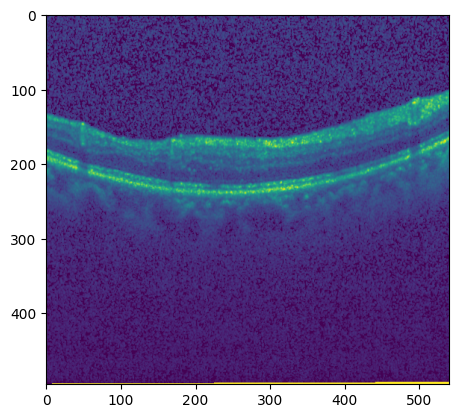

In [74]:
plt.imshow(images[0])

In [75]:
#Saving 110 images and masks sample for training and validation
i = 0
for img, msk in zip(masks,images):
    
    cv.imwrite(f"/Users/anessad/Documents/PROJETS/OCT-AMD-SEGMENTATION/data/sample/images/AMD_image{i}.png",images[i])
    cv.imwrite(f"/Users/anessad/Documents/PROJETS/OCT-AMD-SEGMENTATION/data/sample/masks/AMD_mask{i}.png",masks[i])
    i += 1

In [62]:
path = "../data/sample"

images_path = [path + "/images" + "/" + x  for x in  sorted(os.listdir(path + "/images"))][1:]
masks_path = [path + "/masks" + "/" + x for x in  sorted(os.listdir(path + "/masks"))][1:]

print(images_path[0], masks_path[0])
len(images_path) == len(masks_path)

images = [cv.imread(x,0) for x in images_path] 
masks = [cv.imread(x,0) for x in masks_path]

testset = OCTSegmentation(images[80:],masks[80:],get_train_augs(RESIZE))
dloader_test = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE,shuffle=False)

../data/sample/images/AMD_image0.png ../data/sample/masks/AMD_mask0.png
